The purpose of this notebook is to demonstrate the use of the diff_register package for cell morphology analyses including the entire process from raw microscopy images to quantification and statistical analyses on cell morphological properties. By the end of the demonstration, users will be able to

* Use filters to **clean up** raw images
* Create **binary images** from input images
* Perform **morphological operations** on binary images such as dilation and erosion
* **Segment and label** individual cells from binary images
* **Output dataframes** of cell morphological quantities

Before jumping into the body of the analysis, I would like to help conceptualize the process of morphology analysis into two sets of functions: 

* Input raw image file, output binary image
* Input binary image, output cell morphological quantities

It's helpful in data science to think in terms of inputs and outputs. Diff_classifier provides two powerhouse functions that performs these two steps for you, but users can easily create their own functions using the principles demo'd in the previous training notebook to refine their analyses. Mix and match as you see fit.

# Importing and Prepping Images

We're going to use Mike's CD11b images, since they're so pretty. We'll read them in from AWS using my diff_classifier `aws` module.

In [1]:
from diff_classifier import aws as aws

In [2]:
filename = 'ipsilateral_s1_t3.tif'
folder = '12_11_18_CD11b_microglia_images'
bucket = 'mckenna.data'

aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name=bucket)

Let's read in the file using `scikit-image`'s `imread` command.

In [3]:
import skimage.io as sio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
image = sio.imread(filename)

Let's check some of the image properties before going further to make sure we know what we're dealing with.

In [5]:
image.shape

(2, 512, 512)

Ah, ok, so we have a 2D image with two channels. Let's see what's in each one.

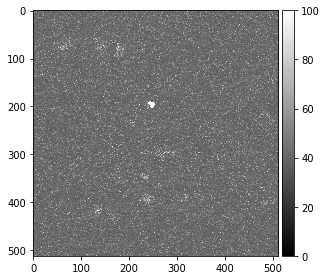

In [6]:
sio.imshow(image[0, :, :], cmap='gray', vmin=0, vmax=100)

The DAPI channel doesn't seem too exciting, but let's check out the GFAP channel:

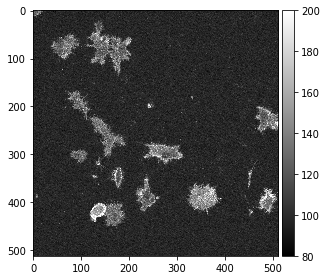

In [7]:
sio.imshow(image[1, :, :], cmap='gray', vmin=80, vmax=200)

Now we're getting something exciting! Before we do anything else, let's create a variable that only has the channel of interest for easier manipulation.

In [8]:
mglia = image[1, :, :]

# Binarizing Input Images

The final flow of diff_register isn't set in stone yet. In fact, I significantly edited the flow this weekend to completely leave the binary step open to the user, because my self-built functions were a bit clunky, and its easier for the user to directly manipulate binarization steps in the notebook itself. I want you to toy with the binarization steps, maybe even build your own inspired from a few methods below. All these use the commands found in the training notebook, including:

* Filters (e.g. mean and median)
* Edge detectors
* Background subtraction
* Simple thresholding
* Opening and closing operations
* Fill homes
* Remove small objects

In [39]:
from skimage.filters import sobel, prewitt, scharr, gaussian, median, rank
from skimage.morphology import square, opening, closing, skeletonize, star, disk, dilation
from skimage.morphology import remove_small_objects, reconstruction, white_tophat
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import regionprops, label
from skan import csr, draw
import numpy as np

from diff_register import im_process as imp

The first binarization function I built looked something like this (but a lot messier-- now it looks nice and tidy, with easy one-liners of code with a defined task). 

The basic idea is to filter the image to get rid of noise, subtract background, threshold such that anything greater than *x* is defined as cell, fill holes, and remove small objects.

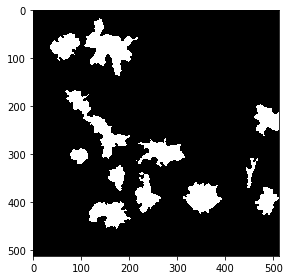

In [22]:
# Old binarization
filt_image = median(mglia, selem=star(2))
backg = median(mglia, selem=star(15))
filt_min = filt_image - 0.5*backg
biim = filt_min > 51
fullim = closing(biim, selem=star(1))
filled_im = binary_fill_holes(fullim)
clean_im1 = remove_small_objects(filled_im, min_size=350)

sio.imshow(clean_im1, cmap='gray')

You may or may not like this second workflow better. Instead of using a simple thresholding technique, I use an edge detector. Edge detectors seem to catch more detail at the cell edges, but it could potentially mess with the skeletonization process downstream. Each individial "bump" will be counted as a process.

(-0.5, 511.5, 511.5, -0.5)

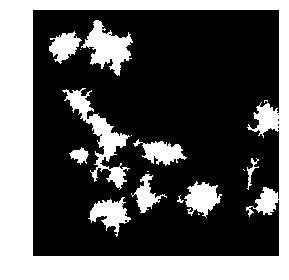

In [23]:
#New binarization

edges = canny(mglia/255., sigma=0.001)
fullim = closing(edges, selem=star(1))
filled_im = binary_fill_holes(fullim)
clean_im2 = remove_small_objects(filled_im, min_size=350)

sio.imshow(clean_im2)
plt.axis('off')

The final binarization workflow is based off a design I used for studying diffusion in and out of cells in *in vitro* cell culture. This particular implementation doesn't capture a lot of the winding at cell edges with may or may not be good for your downstream analysis.

(-0.5, 511.5, 511.5, -0.5)

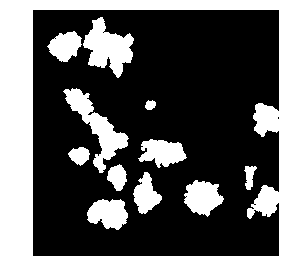

In [24]:
# Alternate binarization
filt_image = rank.mean(mglia, selem=star(2))
edge = prewitt(filt_image)
#closeim = closing(edge, selem=star(1))
openim = opening(edge, selem=star(2))
backg = 1*np.mean(openim)
binarim = openim > backg

seed = np.copy(binarim)
seed[1:-1, 1:-1] = binarim.max()
mask = binarim
filledim = reconstruction(seed, mask, method='erosion')
filled_im = binary_fill_holes(filledim)
clean_im3 = remove_small_objects(filled_im, min_size=350)

sio.imshow(clean_im3)
plt.axis('off')

## Skeletonization

In order to calculate branch features associated with each cell, we need to create a skeletonized image from the binarized image. Here's what the raw output of the `skimage.morphology.skeletonize` function looks likeafter a dilation step to make them clearer:

(-0.5, 511.5, 511.5, -0.5)

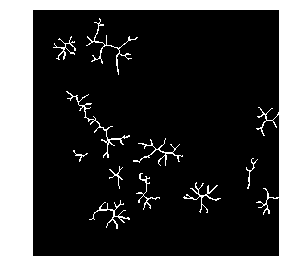

In [41]:
skelim = dilation(skeletonize(clean_im1), selem=disk(1))
#skelim = skeletonize(clean_im1)
sio.imshow(skelim, cmap='gray')
plt.axis('off')

Make sure to compare how the skeletons differ depending on the binary image you use.

(-0.5, 511.5, 511.5, -0.5)

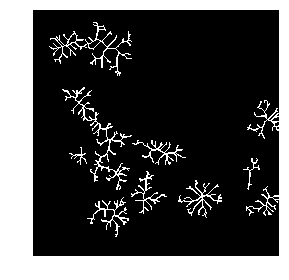

In [42]:
skelim = dilation(skeletonize(clean_im2), selem=disk(1))
#skelim = skeletonize(clean_im1)
sio.imshow(skelim, cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

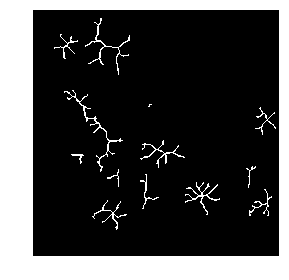

In [43]:
skelim = dilation(skeletonize(clean_im3), selem=disk(1))
#skelim = skeletonize(clean_im1)
sio.imshow(skelim, cmap='gray')
plt.axis('off')

I have wrapped the skeletonization process up with the calculation of branch properties in a single function called `imp.labelandskel`. It creates a `class` object with the skeletonized image and the output properties.

In [14]:
skel = imp.labelandskel(clean_im)

# Morphological Analysis

The final function `imp.mglia_features` unpacks the skeletonized object into a human-readable array using `pandas`. And wallah! Data!

In [15]:
Dfeatures = imp.mglia_features(skel, umppx=1.24)

Let's take a look at the data using the `head` function.

In [44]:
Dfeatures.head()

,X,Y,perimeter,area,eccentricity,inertia_tensor,label,moments,solidity,total_branches,average_branch,main_branch
0,96.999721,193.621166,687.381832,11239.8560,0.650566,"[[686.6681209145129, -184.87716539942102], [-1...",1,"[[7310.0, 476799.0, 36150263.0, 3005494233.0],...",0.760745,15,28.394181,63.134407
1,92.309218,82.745358,312.665105,4700.4432,0.591172,"[[276.4567730619056, 49.21053082694744], [49.2...",2,"[[3057.0, 96121.0, 3733191.0, 163081105.0], [1...",0.919952,10,18.270044,31.955719
2,301.584383,164.786269,881.578447,11149.1376,0.937223,"[[988.9904376630379, -1051.044784410583], [-10...",3,"[[7251.0, 581626.0, 60987216.0, 7215104638.0],...",0.612105,32,16.816147,50.307080
3,244.995114,302.598750,90.234245,541.2352,0.504645,"[[30.638227982954547, 3.7197265625], [3.719726...",4,"[[352.0, 3371.0, 41711.0, 583505.0], [3531.0, ...",0.948787,3,3.993823,5.640250
4,281.198731,600.597779,308.929985,4263.7648,0.578507,"[[192.77799017339035, -11.713691566804695], [-...",5,"[[2773.0, 93653.0, 3956383.0, 187542587.0], [7...",0.879759,8,22.440822,30.972101


We can get a quick summary of the stats using the `describe` function:

In [45]:
Dfeatures.describe()

,X,Y,perimeter,area,eccentricity,label,solidity,total_branches,average_branch,main_branch
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.00000,13.000000,13.000000,13.000000,13.000000
mean,353.823826,315.031226,374.352036,4985.963692,0.686462,7.00000,0.850377,11.230769,18.933546,38.830666
std,143.665509,180.487109,214.481358,3340.677447,0.156184,3.89444,0.094361,7.854445,6.641650,15.715589
min,92.309218,82.745358,90.234245,541.235200,0.424961,1.00000,0.612105,3.000000,3.993823,5.640250
25%,281.198731,193.621166,215.841861,2406.344000,0.578507,4.00000,0.820466,5.000000,16.816147,27.739915
50%,375.333466,291.282509,351.193229,4511.318400,0.690647,7.00000,0.879759,10.000000,18.577758,41.416423
75%,476.641377,437.697185,397.337601,6201.140800,0.769122,10.00000,0.919952,15.000000,22.285280,50.307080
max,524.892646,600.597779,881.578447,11239.856000,0.937223,13.00000,0.948787,32.000000,29.849272,63.134407


And for a quick look at the distribution we can use the `plot` or `hist` functions:

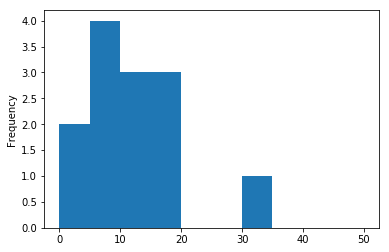

In [49]:
Dfeatures['total_branches'].plot('hist', bins=np.linspace(0, 50, 11))

For analyses that have a number of subimages, you can use the pandas `append` function to create one big master dataset using a for loop on some set of the above steps. But I will leave that up to you!